# Raster processing

In [1]:
import requests
import pandas as pd
import zipfile
import os
import rasterio

from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
from pyproj import CRS

from matplotlib.colors import Normalize
import math

C:\Users\klasique computers\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\klasique computers\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
#!pip3 install rioxarray

In [3]:
# import custom scripts
import sys
sys.path.append('scripts')
import importlib

import raster
importlib.reload(raster)

from raster import (
    RasterProcessor, RasterPlotter,
    DirectoryManager as dm,RasterProperties as R_prop)

In [71]:

#drive.mount('/content/drive')
#data_path = '/content/drive/MyDrive/Thesis/data/'
Processed_files = 'Processed files/'
raw_database = r"C:\Users\Documents\ArcGIS\Projects\THESIS\RAW RASTER DATA"

#practice_data = os.path.join(data_path, 'practice/')
#raster_and_vector_data = os.path.join(data_path, 'raster_and_vector_data/')
processed_data  = r'C:\Users\Documents\ArcGIS\Projects\THESIS\PROCESSED DATA'
#DEM = processed_data + 'geol_layers/DEM.tif'
Hessen_path = '../data/Hessen boundaries/AOI_Hessen.shp'
Hessen = gpd.read_file(Hessen_path)

caco3= os.path.join(raw_database + '/Soil properties/Soil chemical properties/CaCO3.tif')
CEC= os.path.join(raw_database + '/Soil properties/Soil chemical properties/CEC.tif')
soil_chem = r'C:\Users\Documents\ArcGIS\Projects\THESIS\RAW RASTER DATA\Soil properties\Soil chemical properties'
soil_phy = r'C:\Users\Documents\ArcGIS\Projects\THESIS\RAW RASTER DATA\Soil properties\Soil Physical properties'

# '‘3-degree Gauss-Kruger zone 3, EPSG:31467’'

In [5]:
# Verify if the directory exists
def list_dir_folders(dir_path):
    if os.path.exists(dir_path):
        for f in os.scandir(dir_path):
            print(f.name)
    else:
        print(f"The directory {dir_path} does not exist.")

list_dir_folders(raw_database)

DATA_Erosivity
DATA_Soil moisture
DATA_Temperature
Practice
PRECIPITATION
Raster data.rar
Seasonal air temperature
Soil properties


In [6]:
from raster import RasterProperties
from raster import check_tifs_CRS
soil_chem

raster_plotter = RasterPlotter(colormap='terrain', figsize=(15, 30), columns=2)
raster_plt = RasterPlotter()

from raster import RasterProcessor as RP, RasterPlotter 
#raster_plt.plot_raster(caco3)

In [8]:
#raster_plotter = RasterPlotter()
#raster_plotter.check_tifs_CRS(soil_chem)

#soil_chem_properties = RasterProperties(soil_chem)
#check_tifs_CRS(soil_chem)

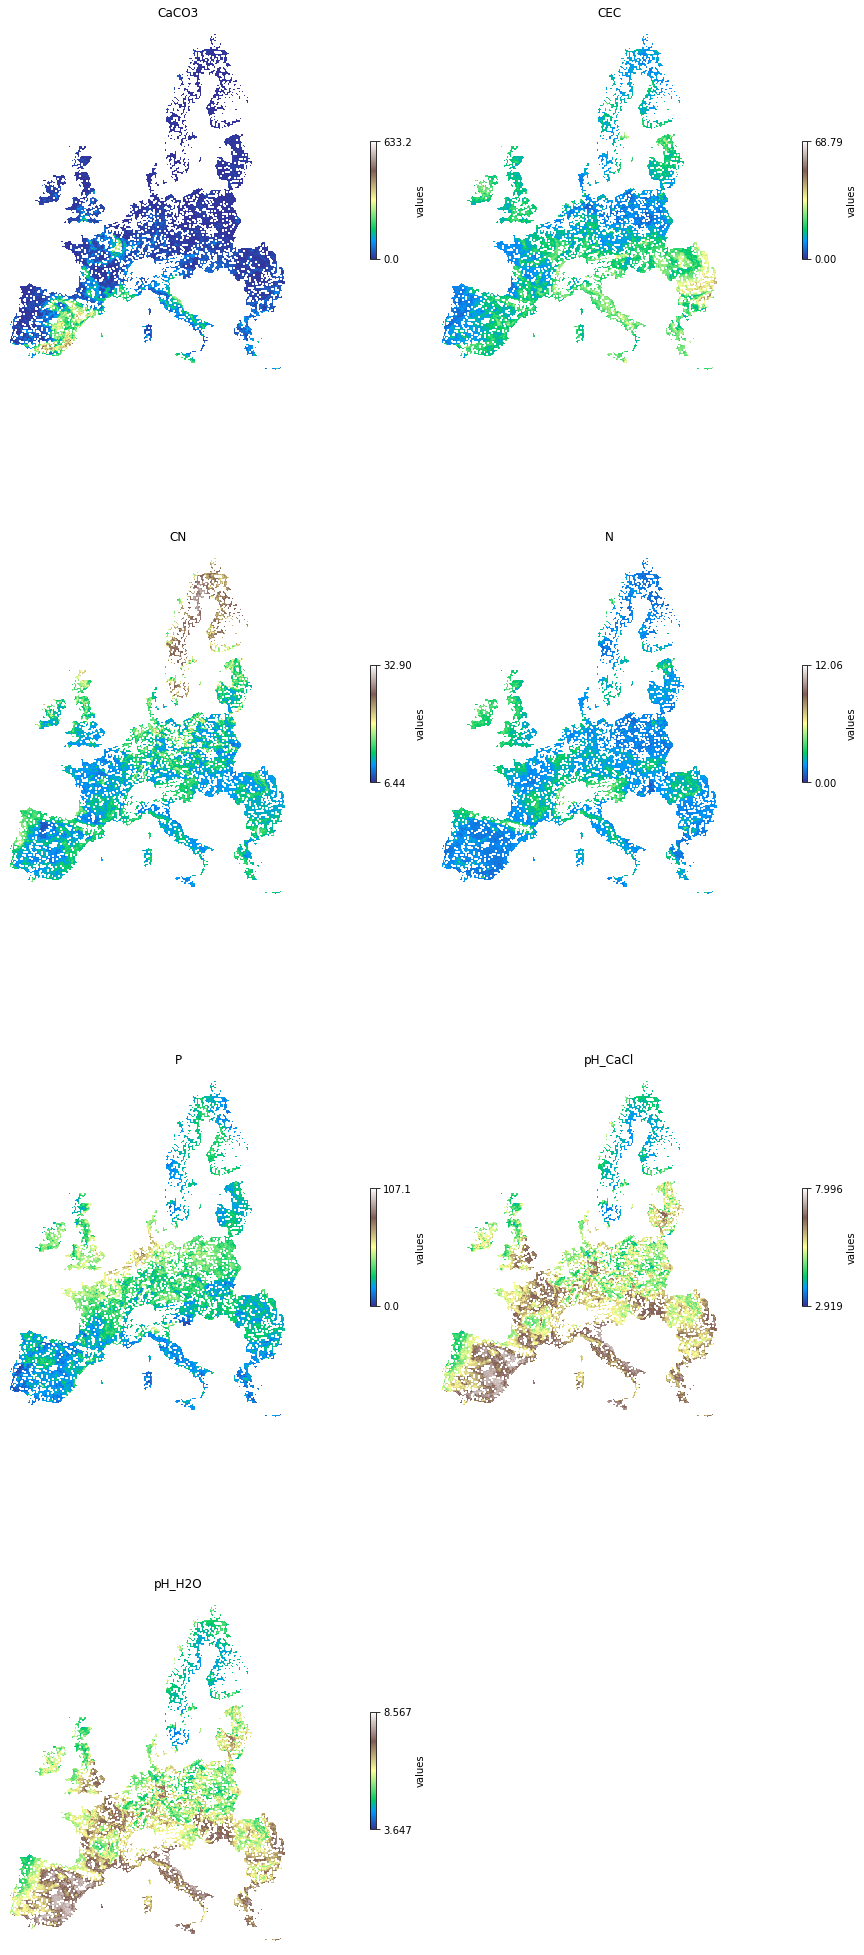

In [11]:
batch_raster = RasterPlotter(colormap='terrain', figsize=(12, 30), columns=2)

# raster_plotter.plot_rasters(precip)
batch_raster.plot_downsample_rasters(soil_chem)

In [12]:
from raster import DirectoryManager
dm = DirectoryManager()
folder_paths=dm.create_subfolders(
    base_path=os.getcwd(),
    subfolders=['soilchem', 'soilhydr', 'temp_pro', 'caco3_pro', 'soilphy'])

soilchem_path=folder_paths['soilchem']
soilphy_path=folder_paths['soilphy']
temp_propath=folder_paths['temp_pro']
caco3_path=folder_paths['caco3_pro']
soilphy_path

## Import raster processor

In [107]:
from raster import RasterProcessor
raster_processor = RasterProcessor()

batch_raster = RasterPlotter(colormap='terrain', figsize=(12, 30), columns=2)

### Test process Caco3

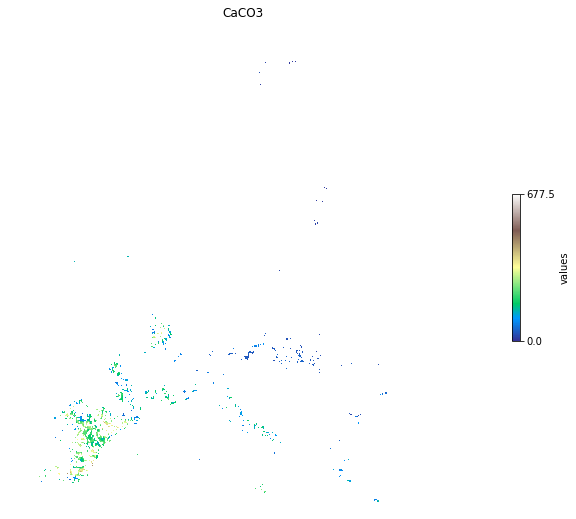

In [112]:
# Initialize single raster plotter
single_raster = RasterPlotter()#colormap='terrain', figsize=(18, 18))

caco3_path
base_name_caco3, ext = os.path.splitext(caco3)

reprojected_co3 = os.path.join(caco3_path, f"caco3_reprojected{ext}")
raster_processor.reproject_raster(caco3, reprojected_co3)

caco3
reprojected_co3
#reprojected_co3
single_raster.plot_raster(caco3)

### Fill the raster

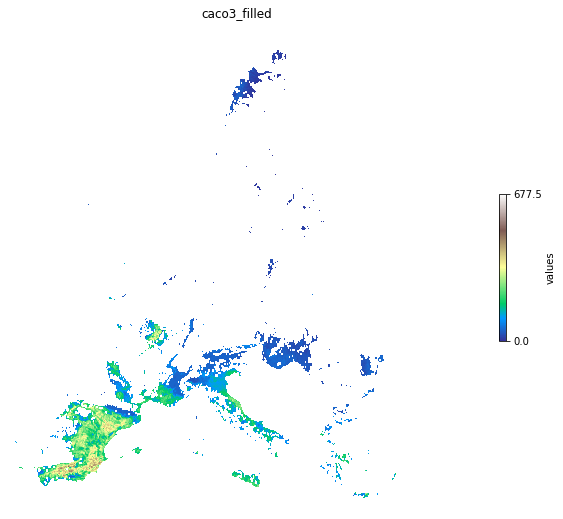

In [114]:
fill_co3= os.path.join(caco3_path, f"caco3_filled{ext}")
raster_processor.fill_raster(reprojected_co3, fill_co3)

single_raster.plot_raster(fill_co3)

### Clip to ROI

Raster resolution: (512.5958140515862, 512.5958140515862)


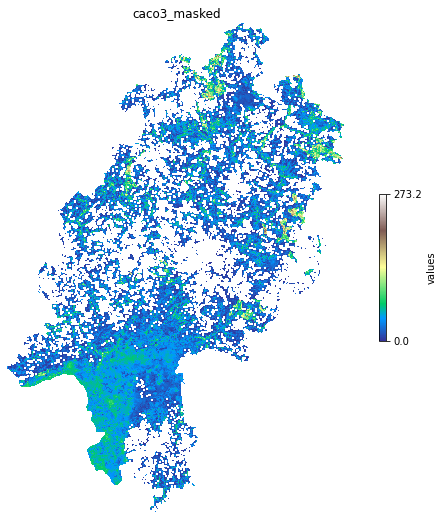

In [117]:
clipped_co3 = os.path.join(caco3_path, f"caco3_clipped{ext}")
masked_co3 = os.path.join(caco3_path, f"caco3_masked{ext}")

raster_processor.mask_raster(fill_co3, Hessen, masked_co3)

#single_raster.print_raster_metadata(masked_co3)

print (F"Raster resolution: {R_prop(masked_co3).raster_resolution()}")
single_raster.plot_raster(masked_co3)

### resample raster to 250x250m

Raster resolution: (250.02874958775212, 250.1712638299574)


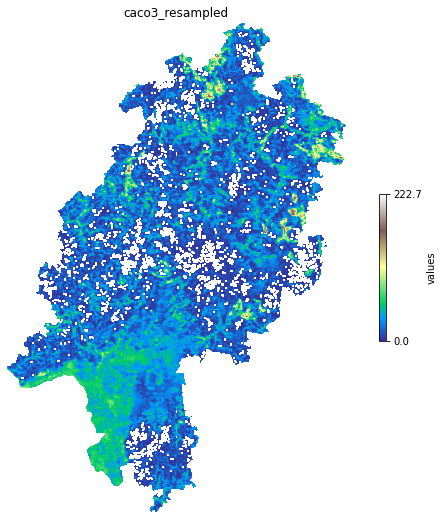

In [119]:
resampled_co3 = os.path.join(caco3_path, f"caco3_resampled{ext}")
raster_processor.resample_raster(masked_co3, resampled_co3)

print (F"Raster resolution: {R_prop(resampled_co3).raster_resolution()}")
single_raster.plot_raster(resampled_co3)

## automate the process for all files

### Soil chemical properties

In [28]:
## Create a reusable function

def batch_processor(rasters_path, output_path ):
    
    tif_files = [f for f in os.listdir(rasters_path) if f.lower().endswith(('.tif', '.tiff'))]

    for tif in tif_files:

        input_path = os.path.join(rasters_path, tif)

        base_name_, ext = os.path.splitext(tif)
        reprojected_path = os.path.join(output_path, f"{base_name_}_reprojected{ext}")
        fill_file= os.path.join(output_path, f"{base_name_}_filled{ext}")
        clipped_path = os.path.join(output_path, f"{base_name_}_clipped{ext}")
        resampled_path = os.path.join(output_path, f"{base_name_}_resampled{ext}")

        # Process raster
        print(f"Processing {tif}...")
        raster_processor.reproject_raster(input_path, reprojected_path)
        raster_processor.fill_raster(reprojected_path, fill_file)
        raster_processor.mask_raster(fill_file, Hessen,clipped_path)
        raster_processor.resample_raster(clipped_path, resampled_path)

        # Delete intermediate files
        os.remove(reprojected_path)
        os.remove(fill_file)
        os.remove(clipped_path)

In [29]:
batch_processor(soil_chem, soilchem_path )

Processing CaCO3.tif...
Processing CEC.tif...
Processing CN.tif...
Processing N.tif...
Processing P.tif...
Processing pH_CaCl.tif...
Processing pH_H2O.tif...


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:620: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:503: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)


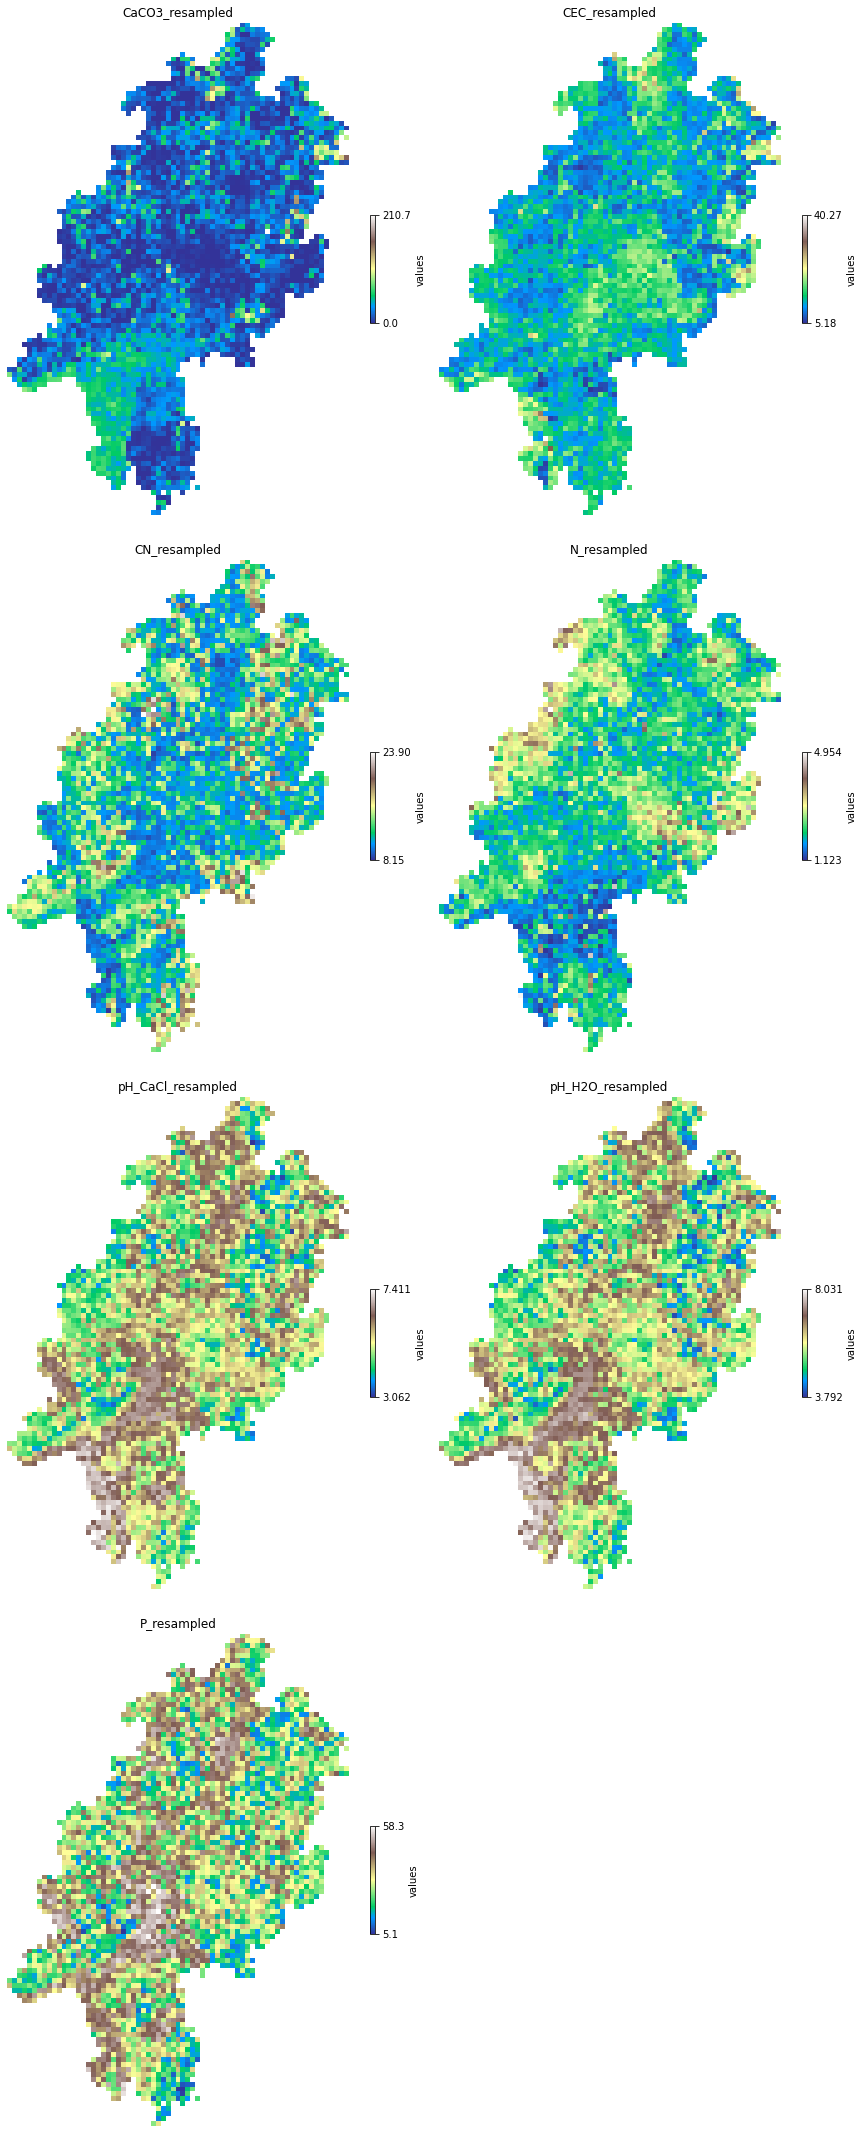

In [30]:
#batch_raster.plot_raster(soilchem_path)
batch_raster.plot_downsample_rasters(soilchem_path)

In [122]:
#soilphy_path

### Soil physical properties

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


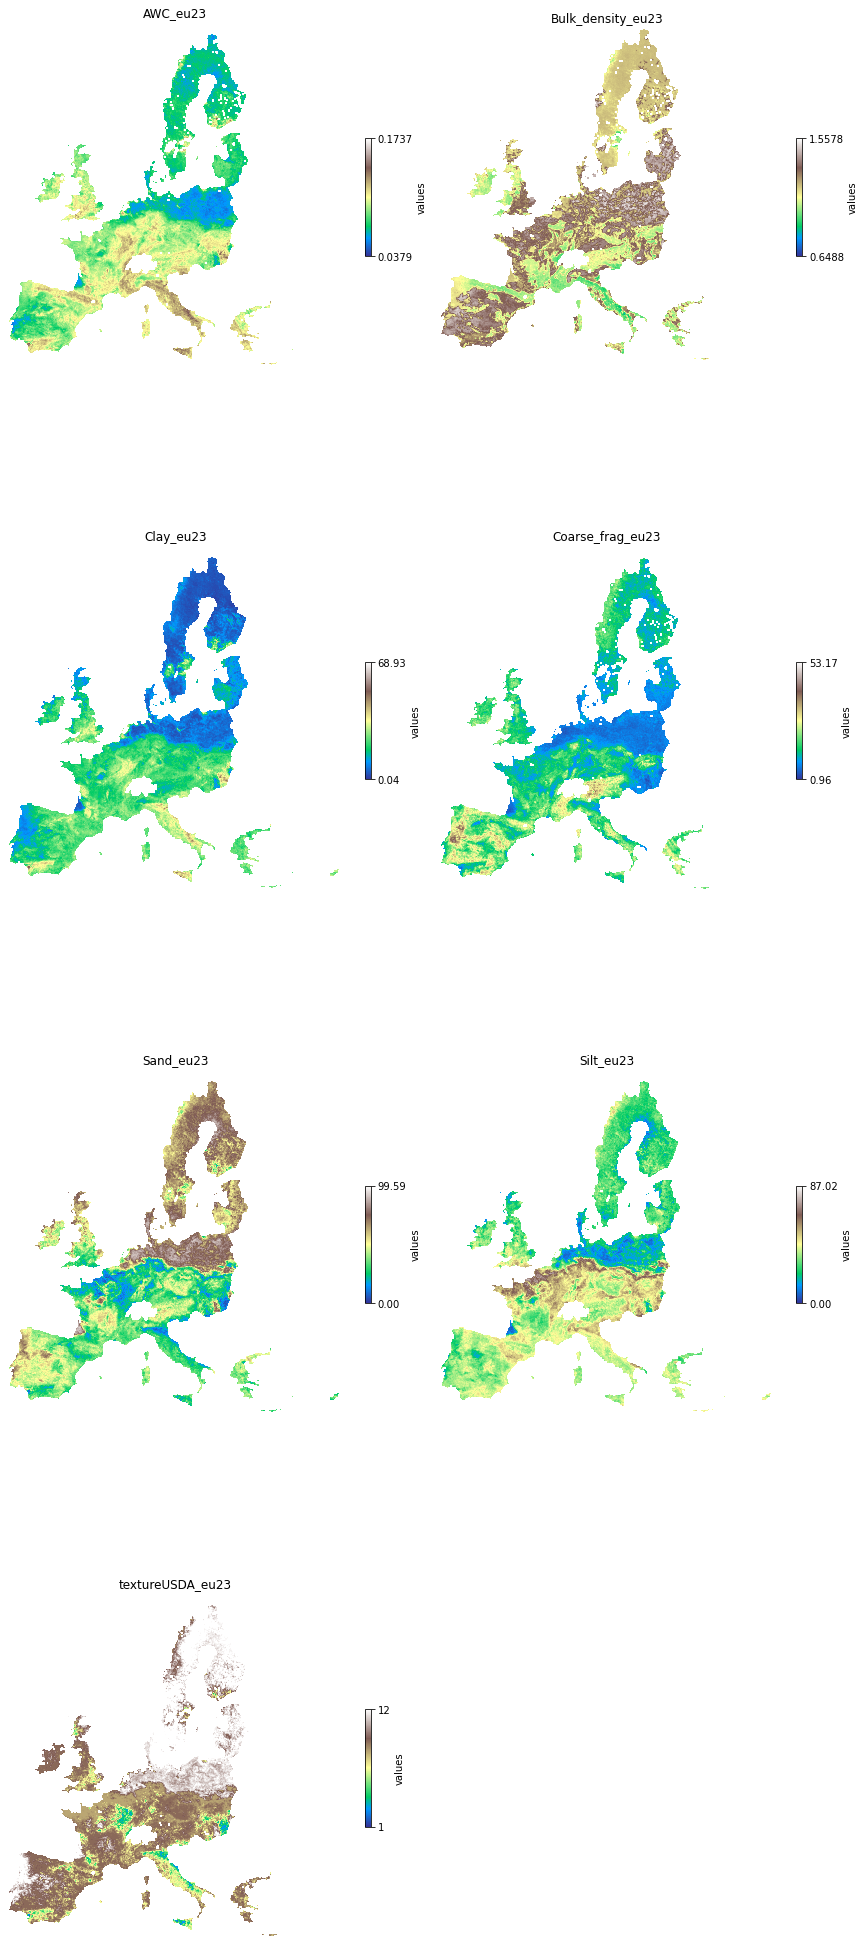

In [32]:
batch_raster.plot_downsample_rasters(soil_phy)

In [35]:
batch_processor(soil_phy, soilphy_path )

Processing AWC_eu23.tif...
Processing Bulk_density_eu23.tif...
Processing Clay_eu23.tif...
Processing Coarse_frag_eu23.tif...
Processing Sand_eu23.tif...
Processing Silt_eu23.tif...
Processing textureUSDA_eu23.tif...


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:620: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


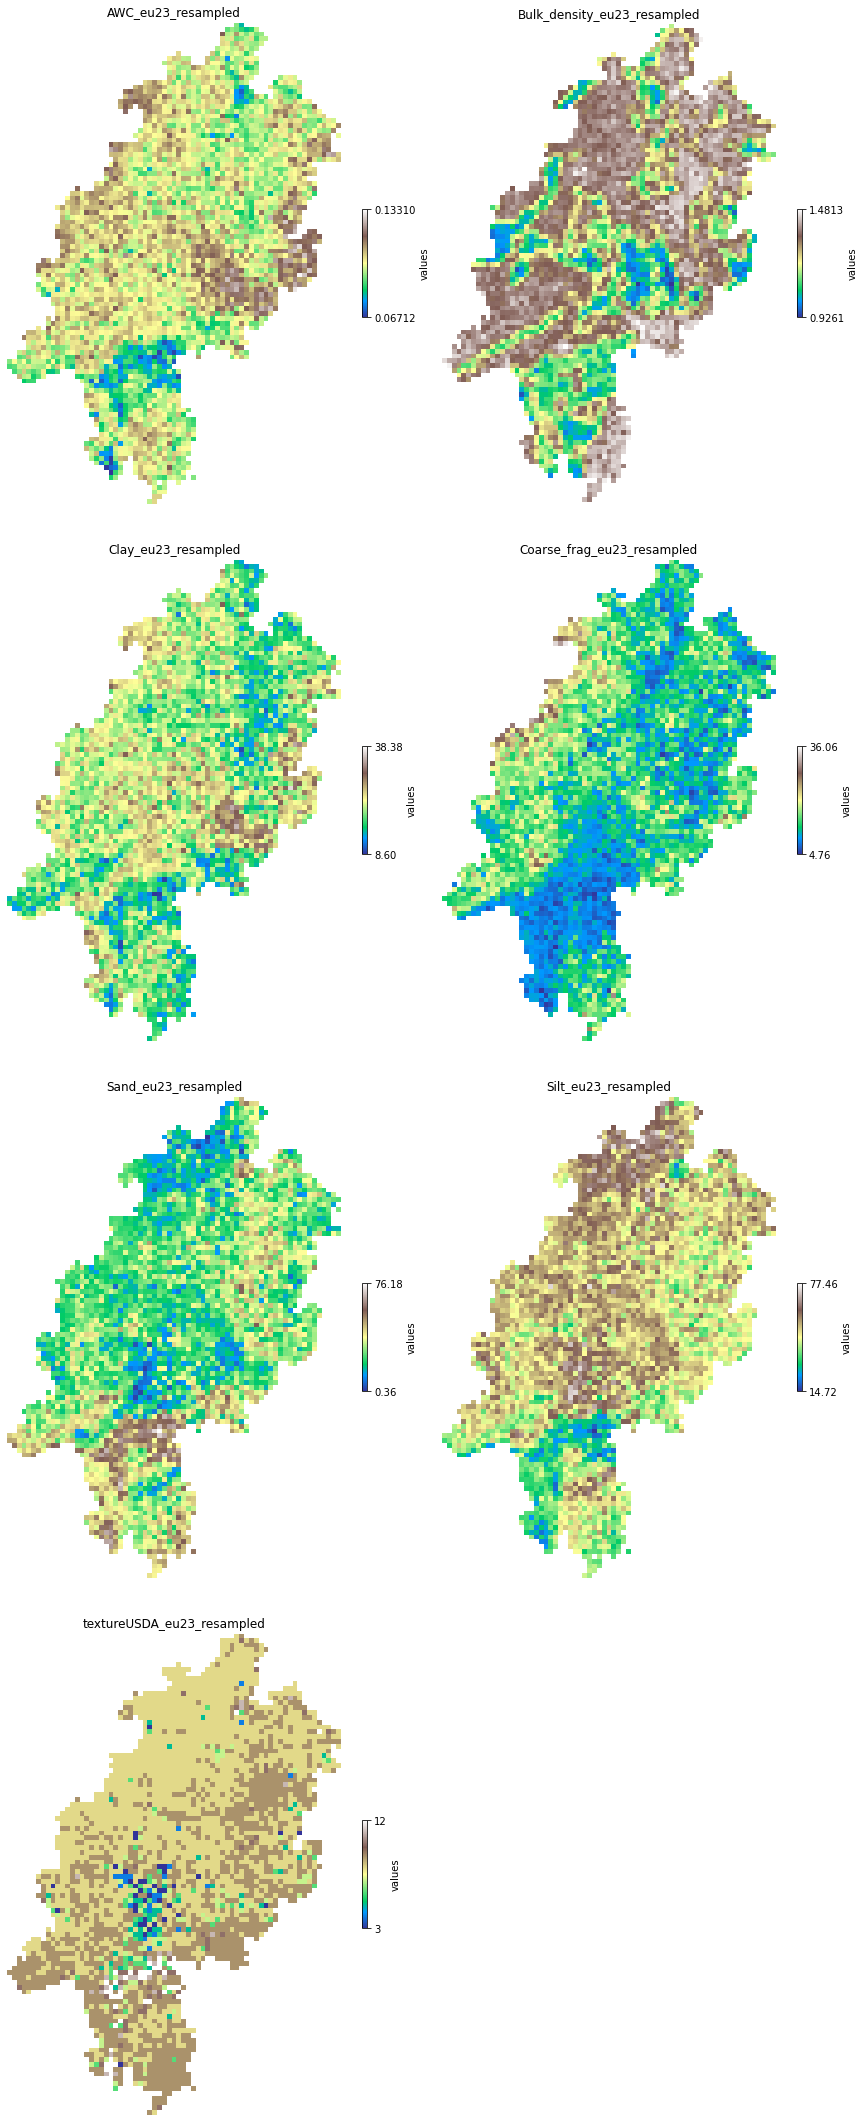

In [36]:
batch_raster.plot_downsample_rasters(soilphy_path)

# Soil Hydraulic Properties

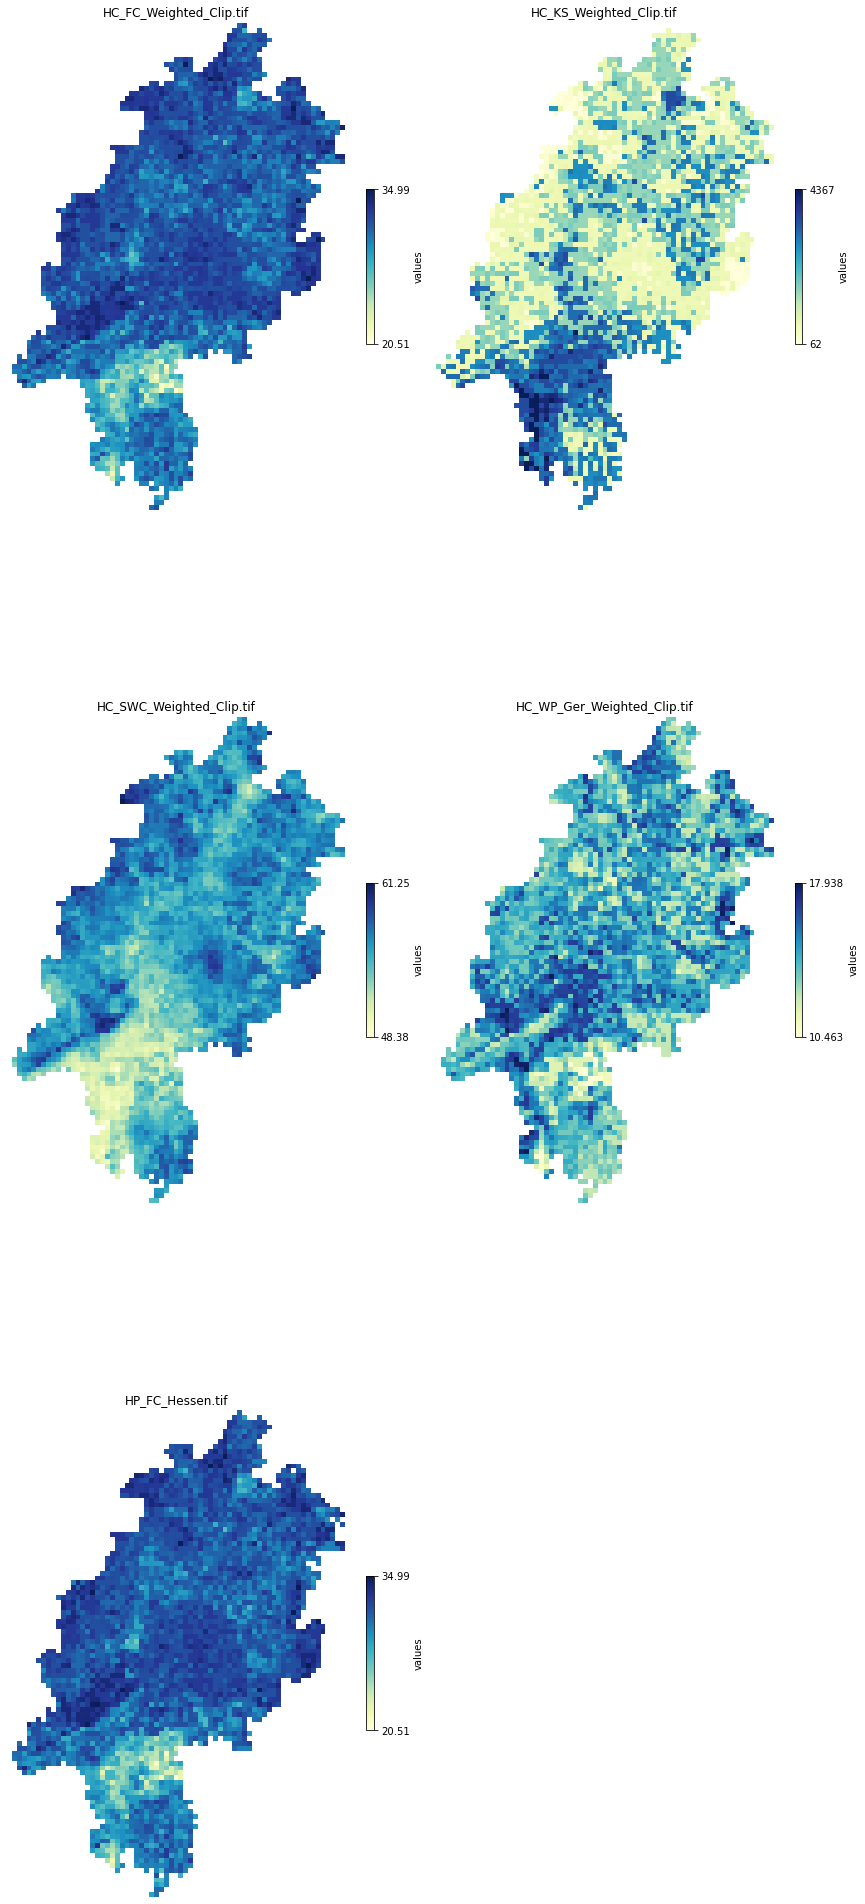

In [130]:
batch_soilhyd = RasterPlotter(colormap='YlGnBu', figsize=(12, 30), columns=2)
batch_soilhyd.plot_downsample_rasters(os.path.join(processed_data, 'soil_hydraulic_ppt'))

# Climate data

## Precipitation

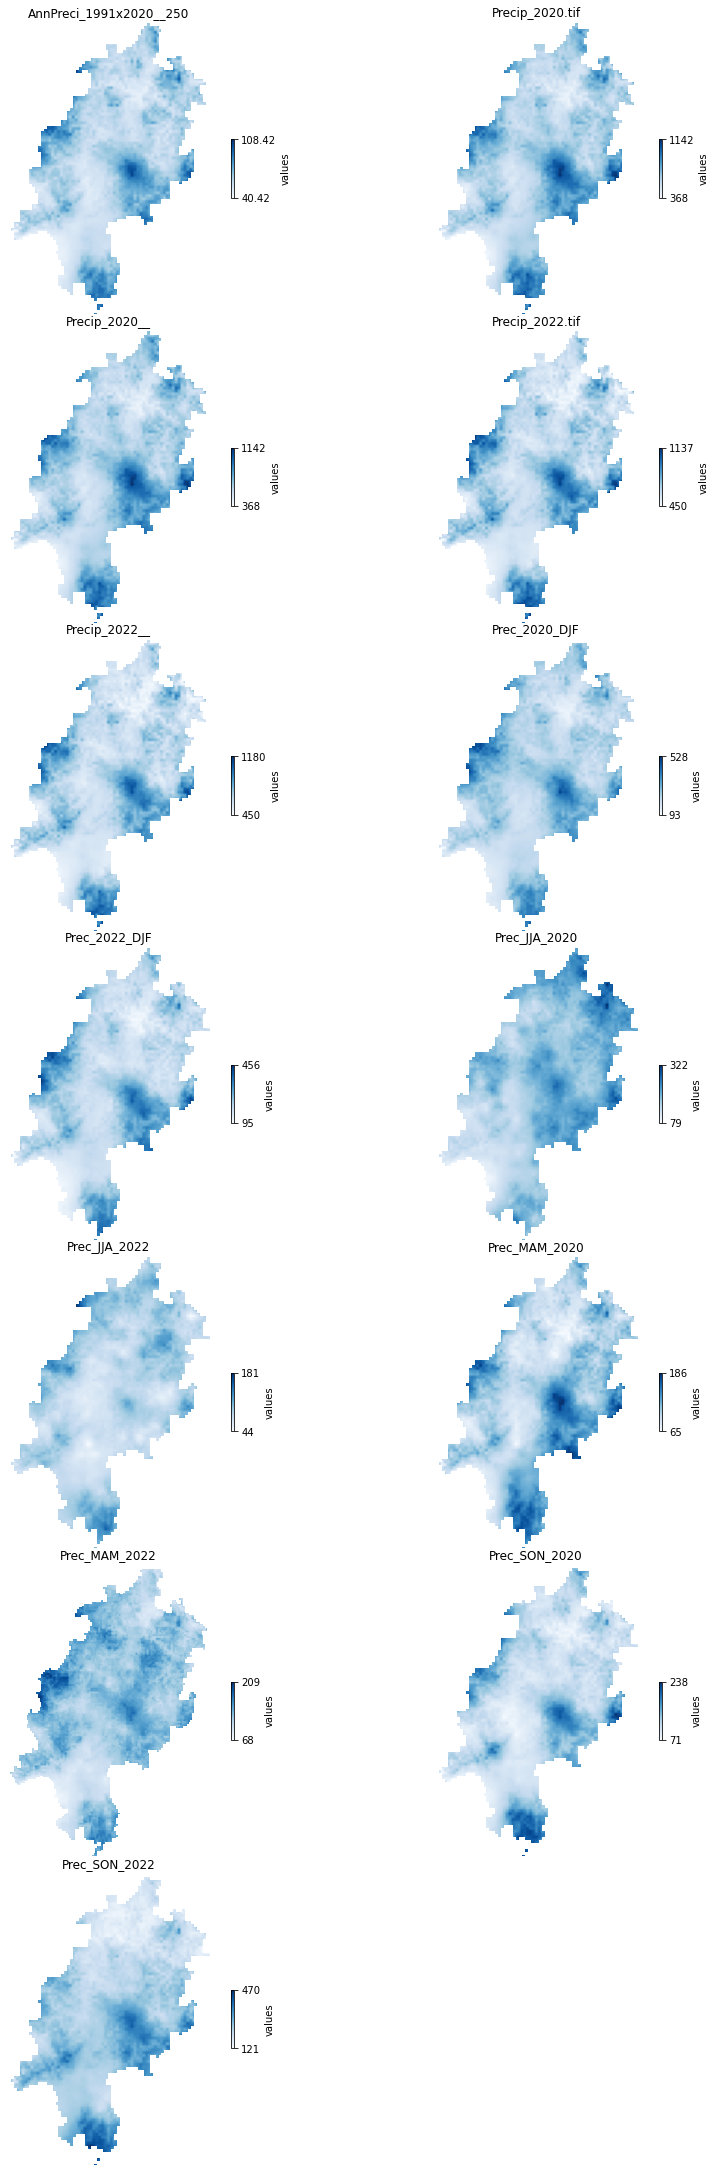

In [104]:
batch_prec = RasterPlotter(colormap='Blues', figsize=(12, 30), columns=2)

batch_prec.plot_downsample_rasters(os.path.join(processed_data, 'prec'))

## Soil Temperature

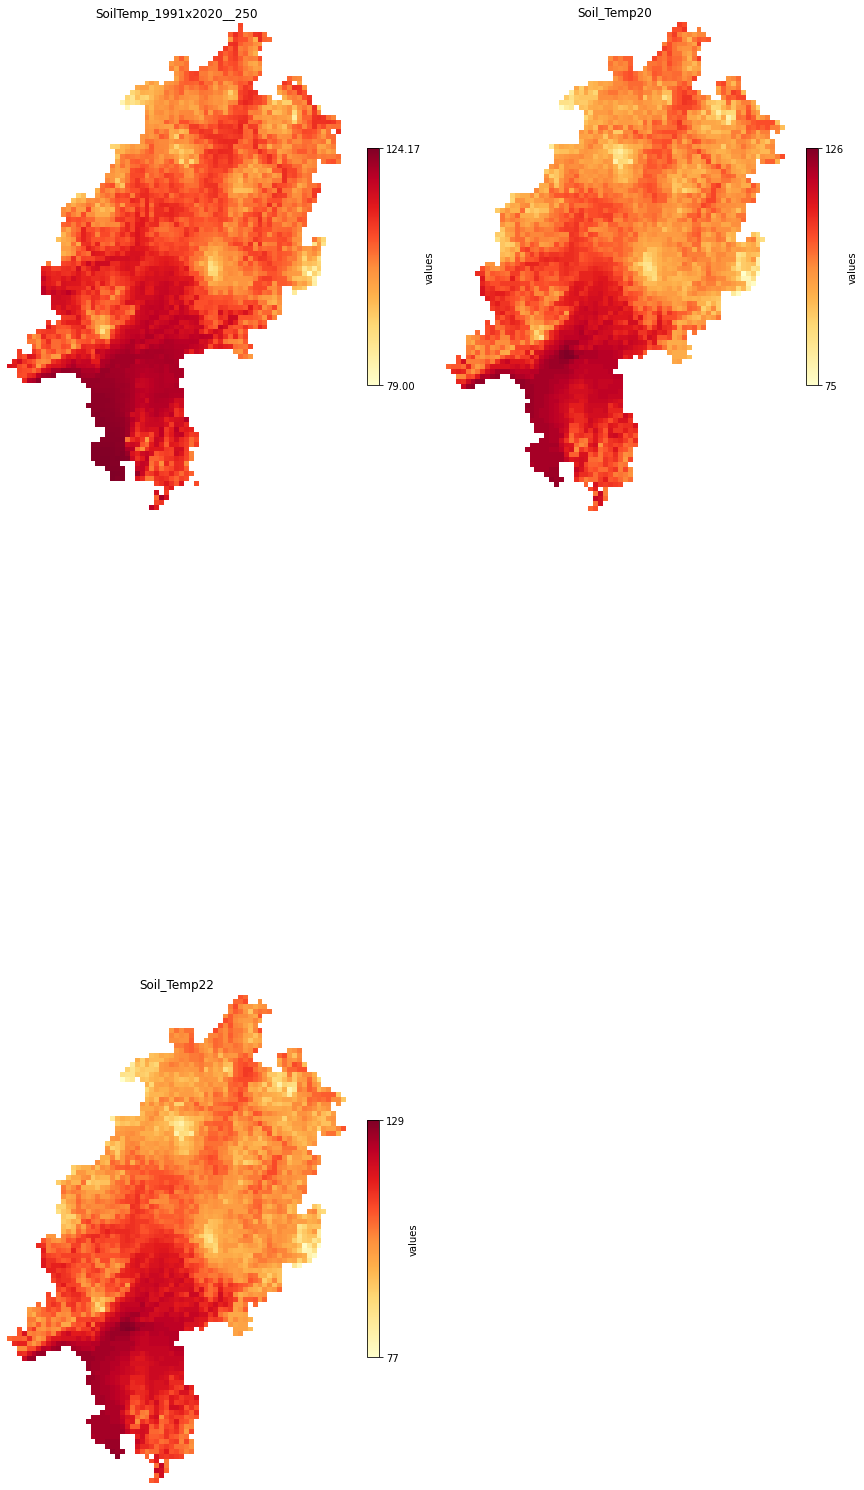

In [106]:
batch_prec = RasterPlotter(colormap='YlOrRd', figsize=(12, 30), columns=2)

batch_prec.plot_downsample_rasters(os.path.join(processed_data, 'soil_temp'))

## Soil Moisture

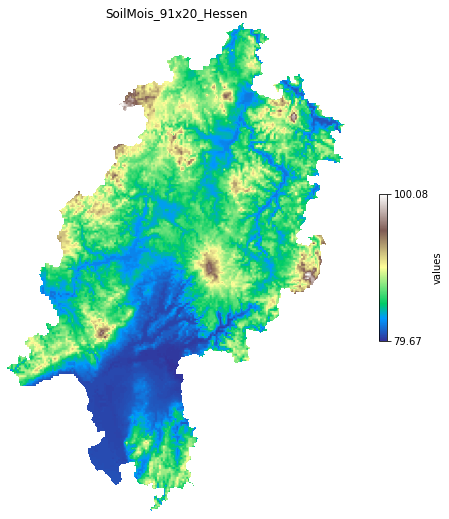

In [128]:
#batch_prec = RasterPlotter(colormap='YlOrRd', figsize=(12, 30), columns=2)
from raster import RasterPlotter

single_raster_moist = RasterPlotter()
single_raster_moist.plot_raster(os.path.join(processed_data,
                                       'soil_moisture\SoilMois_91x20_Hessen.tif'))

## TWI and Lineament Density

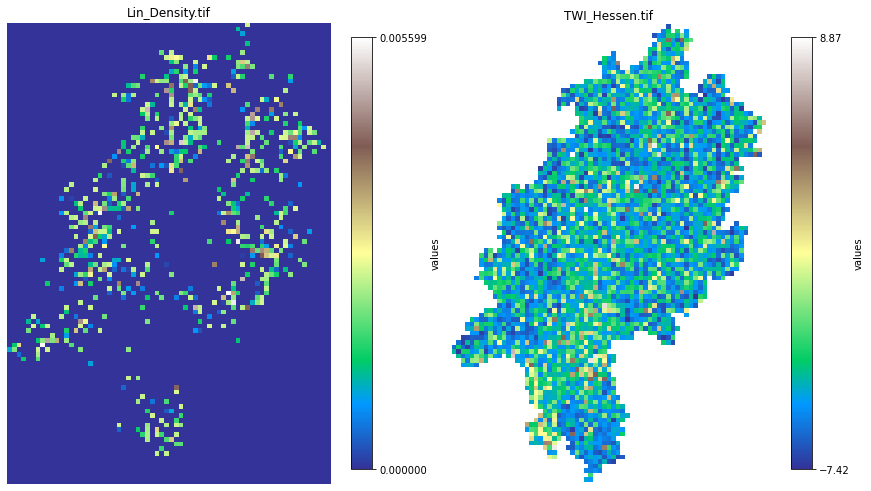

In [133]:
#single_raster_moist.plot_raster(os.path.join(processed_data,
#                                       'soil_moisture\SoilMois_91x20_Hessen.tif'))
batch_raster.plot_downsample_rasters(os.path.join(processed_data, 'geol_layers'))

# DEM

Raster resolution: (250.061190799681, 250.1966219339483)


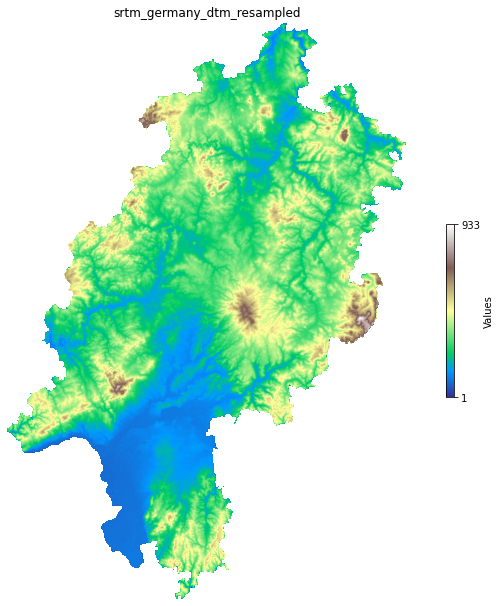

In [56]:
from raster import RasterPlotter
single_plot = RasterPlotter()

DEM_path = 'Downloads/'
DEM_Hessen = 'Downloads/processed/'

batch_processor(DEM_path, DEM_Hessen)

print (f"Raster resolution: {R_prop('Downloads/processed/srtm_germany_dtm_resampled.tif').raster_resolution()}")
single_plot.plot_raster_mask('Downloads/processed/srtm_germany_dtm_resampled.tif')

# Uranium

In [61]:
Geology_processed = os.path.join(Processed_files, 'Geology/')

Uranium = gpd.read_file('Geology.gpkg', layer='Uranium_map', driver="GPKG")
#Hessen = gpd.read_file(Hessen_path, layer='Hessen', driver="GPKG")
print(f"data: {fiona.listlayers('Geology.gpkg')}")
Uranium.head(3)

,Shape_Area,hlnug,p_90,p_50,p_90_class,p_50_class,geometry
0,9.063963e+07,"Triassic, Middle (Muschelkalk)",14.0,6.00,5 - 10,5 - 10,"POLYGON ((526957.795 5719576.918, 526874.515 5..."
1,1.056687e+07,"Triassic, Middle (Muschelkalk)",14.0,6.00,5 - 10,5 - 10,"MULTIPOLYGON (((554799.185 5693488.116, 554799..."
2,1.357802e+08,"Triassic, Lower (Buntsandstein)",6.8,2.29,5 - 10,< 5,"POLYGON ((529681.632 5699891.651, 529525.232 5..."


Raster file saved to Processed files/Geology/Uranium.tif


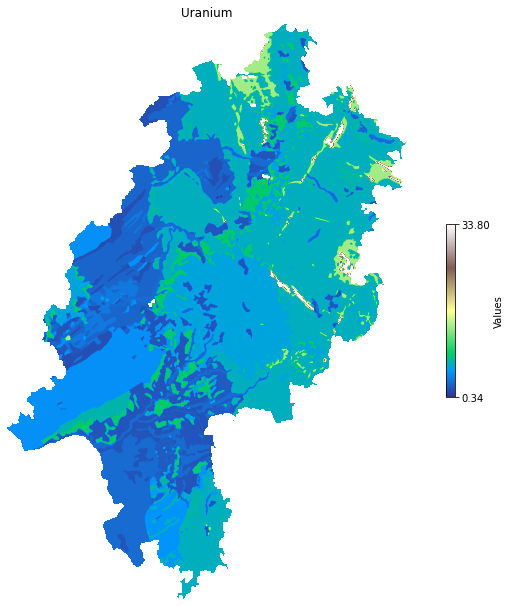

Raster resolution: (250.0, 250.0)


In [78]:
# convert shapefile to raster
RasterProcessor.shapefile_to_raster(Uranium, Geology_processed + 'Uranium.tif', pixel_size=250, value_field='p_90')
single_plot.plot_raster_mask(Geology_processed + 'Uranium.tif')
print (f"Raster resolution: {R_prop(Geology_processed + 'Uranium.tif').raster_resolution()}")

# Geology

In [100]:
Geology_gdf=gpd.read_file('Geology.gpkg', layer='Geology_processed', driver="GPKG")
Geo_processed = os.path.join(processed_data, 'geology_raster')

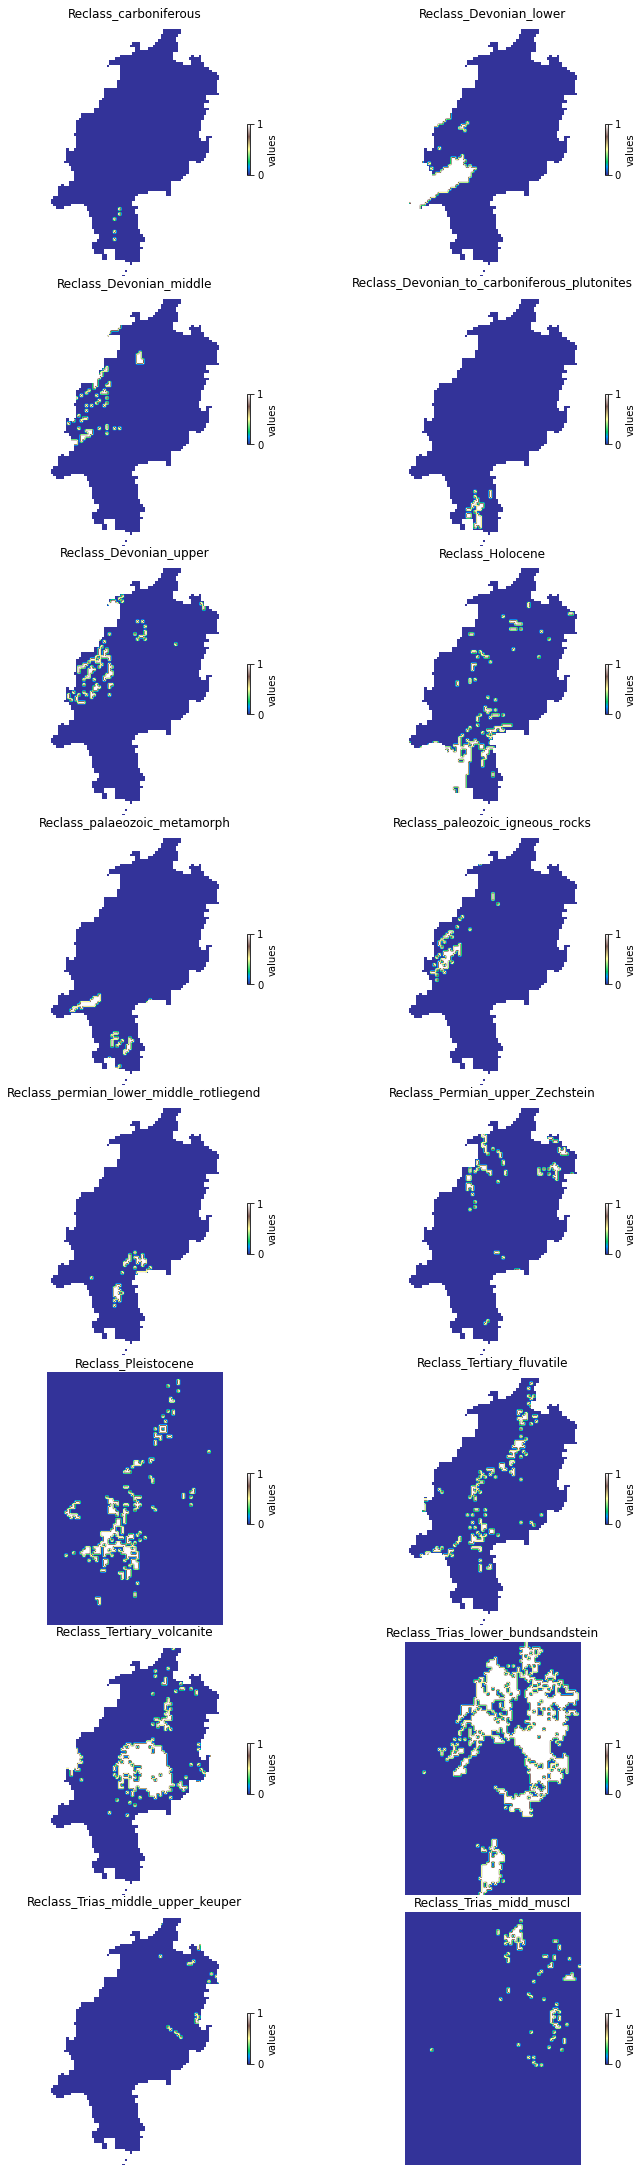

In [102]:
batch_raster.plot_downsample_rasters(Geo_processed)

## Extract values to points

In [149]:
# Extract values from rasters
df_values=RasterProcessor.extract_raster_values(Geo_processed, radon_df)
#print(df_values)
df_values

,geometry,Reclass_carboniferous.tif,Reclass_Devonian_lower.tif,Reclass_Devonian_middle.tif,Reclass_Devonian_to_carboniferous_plutonites.tif,Reclass_Devonian_upper.tif,Reclass_Holocene.tif,Reclass_palaeozoic_metamorph.tif,Reclass_paleozoic_igneous_rocks.tif,Reclass_permian_lower_middle_rotliegend.tif,Reclass_Permian_upper_Zechstein.tif,Reclass_Pleistocene.tif,Reclass_Tertiary_fluvatile.tif,Reclass_Tertiary_volcanite.tif,Reclass_Trias_lower_bundsandstein.tif,Reclass_Trias_middle_upper_keuper.tif,Reclass_Trias_midd_muscl.tif
0,POINT (491746 5523976),0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,POINT (493389.43599999975 5526399.017999999),0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,POINT (470438 5514533),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,POINT (498576.95600000024 5523370.99),0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,POINT (501909 5521366),0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,POINT (475497.2926000003 5511540.864399999),0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1505,POINT (475488.8948999997 5511531.563200001),0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1506,POINT (475486.8156000003 5511533.6850000005),0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1507,POINT (475479.62229999993 5511535.8301),0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
